In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

%matplotlib inline

## QE bands

In [2]:
import qe_utils as qeu

# [[label, scf_output_file, bands_output_dir]]
datafiles = [["QE cnt 6,0",
              "/home/kristjan/local_work/qe_cnt_6-0_bands/scf.out",
              "/home/kristjan/local_work/qe_cnt_6-0_bands/"],
             ["QE cnt 12,0",
              "/home/kristjan/local_work/qe_cnt_12-0_bands/scf.out",
              "/home/kristjan/local_work/qe_cnt_12-0_bands/"]]

# {'label'} = [kpts, eig_vals]
datasets = {}

for df in datafiles:
    kpts, eig_vals = qeu.read_and_shift_bands(df[1], df[2])
    datasets[df[0]] = [kpts, eig_vals]
    
def add_qe_bands_to_plot(label, col, ls, lw, bzboundary):
    kpts_raw, eig_vals = datasets[label]
    # Convert kpts to correct units (from QE: 0.5 corresponds to BZ edge)
    kpts = kpts_raw*bzboundary/0.5
    for n in range(len(eig_vals[0])):
        if n == 0:
            plt.plot(np.abs(kpts[:, 0]), eig_vals[:, n], linestyle=ls, color=col, linewidth=lw, label=label)
        else:
            plt.plot(np.abs(kpts[:, 0]), eig_vals[:, n], linestyle=ls, color=col, linewidth=lw)

## CP2K LDOS stuff

In [3]:
def read_header(ldos_file_path):
    with open(ldos_file_path, 'r') as f:
        header = f.readline()
    vals = []
    for hpart in header.split(';'):
        vals.append(hpart.split(': ')[1].split('(')[0])
        
    geom_name = vals[0]
    height = float(vals[1])
    fwhm = float(vals[2])
    broad_type = vals[3]
    xmin = float(vals[4])
    xmax = float(vals[5])
    nx = int(vals[6])
    emin = float(vals[7])
    emax = float(vals[8])
    ne = int(vals[9])
    
    return geom_name, height, fwhm, broad_type, xmin, xmax, nx, emin, emax, ne
    

In [4]:
def crop_defect(x_arr, ldos, additional_crop, lattice_param):
    e_averaged = np.mean(ldos, axis=1)
    first_half = e_averaged[:len(e_averaged)//2]
    second_half = e_averaged[len(e_averaged)//2:]
    
    dx = x_arr[1]-x_arr[0]
    
    index_l = np.argmax(first_half)
    index_r = np.argmax(second_half) + len(first_half)
    
    crop_x_l = x_arr[index_l] + additional_crop
    crop_x_r = x_arr[index_r] - additional_crop
    
    # align cropping, such that remaining area is a multiple of lattice parameter (minus dx!)
    crop_len = crop_x_r - crop_x_l
    crop_len_goal = np.round(crop_len/lattice_param)*lattice_param - dx
    extra_shift = (crop_len_goal - crop_len)/2
    
    crop_x_l -= extra_shift
    crop_x_r += extra_shift
    
    crop_l = int(np.round(crop_x_l/dx))
    # shift the other end due to putting on grid error
    crop_x_r += np.round(crop_x_l/dx)*dx - crop_x_l
    crop_r = int(np.round(crop_x_r/dx))
    
    return np.copy(x_arr[crop_l:crop_r+1]), np.copy(ldos[crop_l:crop_r+1])

def fourier_transform(ldos, dx, lattice_param):
    
    ft = np.fft.rfft(ldos, axis=0)
    aft = np.abs(ft)

    # Corresponding k points
    k_arr = 2*np.pi*np.fft.rfftfreq(len(ldos[:, 0]), dx)
    # Note: Since we took the FT of the charge density, the wave vectors are
    #       twice the ones of the underlying wave function.
    k_arr = k_arr / 2
    
    # Lattice spacing for the ribbon = 3x c-c distance
    # Brillouin zone boundary [1/angstroms]
    bzboundary = np.pi / lattice_param
    
    dk = k_arr[1]
    bzb_index = int(np.round(bzboundary/dk))+1

    return k_arr, aft, dk, bzboundary, bzb_index

def remove_row_average(ldos):
    ldos_no_avg = np.copy(ldos)
    for i in range(np.shape(ldos)[1]):
        ldos_no_avg[:, i] -= np.mean(ldos[:, i])
    return ldos_no_avg

def add_padding(x_arr, ldos, padding_x, lattice_param):
    if padding_x <= 0.0:
        return x_arr, ldos
    dx = x_arr[1]-x_arr[0]
    init_len = x_arr[-1]-x_arr[0]
    
    # align resulting x-length to lattice param
    pad_len = init_len+2*padding_x
    pad_len_goal = np.round(pad_len/lattice_param)*lattice_param - dx
    padding_x = (pad_len_goal - init_len)/2
    
    pad_n_l = int(np.round(padding_x/dx))
    pad_x_l = pad_n_l*dx
    grid_shift = padding_x - pad_x_l
    pad_n_r = int(np.round((padding_x+grid_shift)/dx))
    pad_x_r = pad_n_r*dx
    
    padded_x_arr = np.arange(x_arr[0]-pad_x_l, x_arr[-1]+pad_x_r+1e-6, dx)
    padded_ldos = np.zeros((np.shape(ldos)[0]+pad_n_l+pad_n_r, np.shape(ldos)[1]))
    padded_ldos[pad_n_l:-pad_n_r] = ldos
    
    return padded_x_arr, padded_ldos

In [5]:
def zoomed_ftldos(k_arr, e_arr, aft, bzboundary, fname, qe_label):
    k_grid, e_k_grid = np.meshgrid(k_arr, e_arr, indexing='ij')
    emin = np.min(e_arr)
    emax = np.max(e_arr)
    plt.figure(figsize=(8, 40*(emax-emin)/1.4))
    plt.pcolormesh(k_grid[:100]*10,
                   e_k_grid[:100],
                   aft[:100],
                   vmax=0.1*np.max(aft))
    add_qe_bands_to_plot(qe_label, 'r', '-', 1.0, bzboundary*10)
    plt.ylim([emin, emax])
    plt.xlim([0.0, 2.0])
    plt.xlabel("k (1/nm)")
    plt.ylabel("E (eV)")
    plt.yticks(np.arange(emin, emax+0.01, 0.01))
    plt.xticks(np.arange(0.0, 2.0, 0.1))
    plt.grid(b=True, which='major', color='w', linestyle='--')
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.close()

In [6]:
#zoomed_ftldos(k_arr, e_arr, aft, "./fig/ldos_sts/zoomed/test.png")

## Processing

In [7]:
def process_ldos(ldos_folder, ldos_file, crop_defect_dist, remove_row_avg, padding_x, elim):
    
    ldos_raw = np.loadtxt(ldos_folder+ldos_file)
    
    geom_name, height, fwhm, broad_type, xmin, xmax, nx, emin, emax, ne = read_header(ldos_folder+ldos_file)
    
    print("xrange:", xmin, xmax, nx)
    print("erange:", emin, emax, ne)
    
    x_arr_whole = np.linspace(xmin, xmax, nx)
    e_arr_whole = np.linspace(emin, emax, ne)
    
    # Crop in space
    lattice_param = 3*1.42
    x_arr, ldos = crop_defect(x_arr_whole, ldos_raw, crop_defect_dist, lattice_param)
    x_crop_l = [x_arr[0], x_arr[-1]]
    
    # Crop in energy
    e_arr = np.copy(e_arr_whole)
    if e_arr[0] < elim[0]:
        index = np.argmax(e_arr>elim[0])-1
        e_arr = e_arr[index:]
        ldos = ldos[:, index:]
    if e_arr[-1] > elim[1]:
        index = np.argmax(e_arr>elim[1])+1
        e_arr = e_arr[:index]
        ldos = ldos[:, :index]

    dx = x_arr[1] - x_arr[0]
    
    print("dx", dx)
    align_check = (x_arr[-1]-x_arr[0])%lattice_param
    print("alignment check:", align_check, align_check - lattice_param)
    
    if remove_row_avg:
        ldos = remove_row_average(ldos)

    x_arr, ldos = add_padding(x_arr, ldos, padding_x, lattice_param)

    align_check = (x_arr[-1]-x_arr[0])%lattice_param
    print("alignment check:", align_check, align_check - lattice_param)
    
    
    fname, ext = os.path.splitext(ldos_file)
    figname = fname + "_crop%.0f_e%.1f_padding%.0f" % (crop_defect_dist, elim[1], padding_x)
    
    return x_arr_whole, e_arr_whole, ldos_raw, x_arr, e_arr, ldos, x_crop_l, lattice_param, figname
    
def plot_ldos(process_output,
              qe_label, brightn=[1.0, 1.0, 1.0]):
    
    x_arr_whole, e_arr_whole, ldos_raw, x_arr, e_arr, ldos, x_crop_l, lattice_param, figname = process_output
    
    dx = x_arr[1] - x_arr[0]
    

    x_grid_whole, e_grid_whole = np.meshgrid(x_arr_whole, e_arr_whole, indexing='ij')
    
    #f, (ax1, ax2, ax3) = plt.subplots(3, figsize=(18.0, 12.0))
    f, (ax1, ax2) = plt.subplots(2, figsize=(18.0, 12.0))
    
    ax1.pcolormesh(x_grid_whole, e_grid_whole, ldos_raw,
                   vmax=brightn[0]*0.3*np.max(ldos_raw))
    ax1.axvline(x_crop_l[0], color='r')
    ax1.axvline(x_crop_l[1], color='r')
    ax1.axhline(e_arr[0], color='r')
    ax1.axhline(e_arr[-1], color='r')
    ax1.set_xlabel("x (angstrom)")
    ax1.set_ylabel("E (eV)")
   
    x_grid, e_grid = np.meshgrid(x_arr, e_arr, indexing='ij')

    #ax2.pcolormesh(x_grid, e_grid, ldos, vmax=brightn[1]*np.max(ldos))
    #ax2.set_xlabel("x (angstrom)")
    #ax2.set_ylabel("E (eV)")
    
    k_arr, aft, dk, bzboundary, bzb_index = fourier_transform(ldos, dx, lattice_param)
    k_grid, e_k_grid = np.meshgrid(k_arr, e_arr, indexing='ij')
    
    # -----------------------------------------
    # Plotting FTSTS

    ax2.pcolormesh(k_grid,
                   e_k_grid,
                   aft,
                   vmax=brightn[2]*0.1*np.max(aft))
    
    if qe_label != "":
        add_qe_bands_to_plot(qe_label, 'r', '-', 0.6, bzboundary)
    ax2.set_ylim([np.min(e_arr), np.max(e_arr)])
    ax2.set_xlim([0.0, 2.0])
    ax2.set_xlabel("k (1/angstrom)")
    ax2.set_ylabel("E (eV)")
    
    plt.savefig("./fig/ldos_sts/"+figname+".png", dpi=300, bbox_inches='tight')
    plt.show()
    
    #zoomed_ftldos(k_arr, e_arr, aft, bzboundary, "./fig/ldos_sts/zoomed/zoom_"+figname+".png", qe_label)
    
    return k_arr, e_arr, aft

In [8]:
proc_out = process_ldos("/home/kristjan/local_work/cnt_molog_ldos/new/",
                                              "ldos_cnt120-h-D-periodic_h1.0_fwhm0.01g.txt",
                                              5.0, True, 300.0, [-0.7, 0.7])

xrange: 0.0 506.8548 5950
erange: -2.0 2.0 2001
dx 0.0852
alignment check: 4.1748 -0.0852
alignment check: 4.17479999988 -0.0852000001202


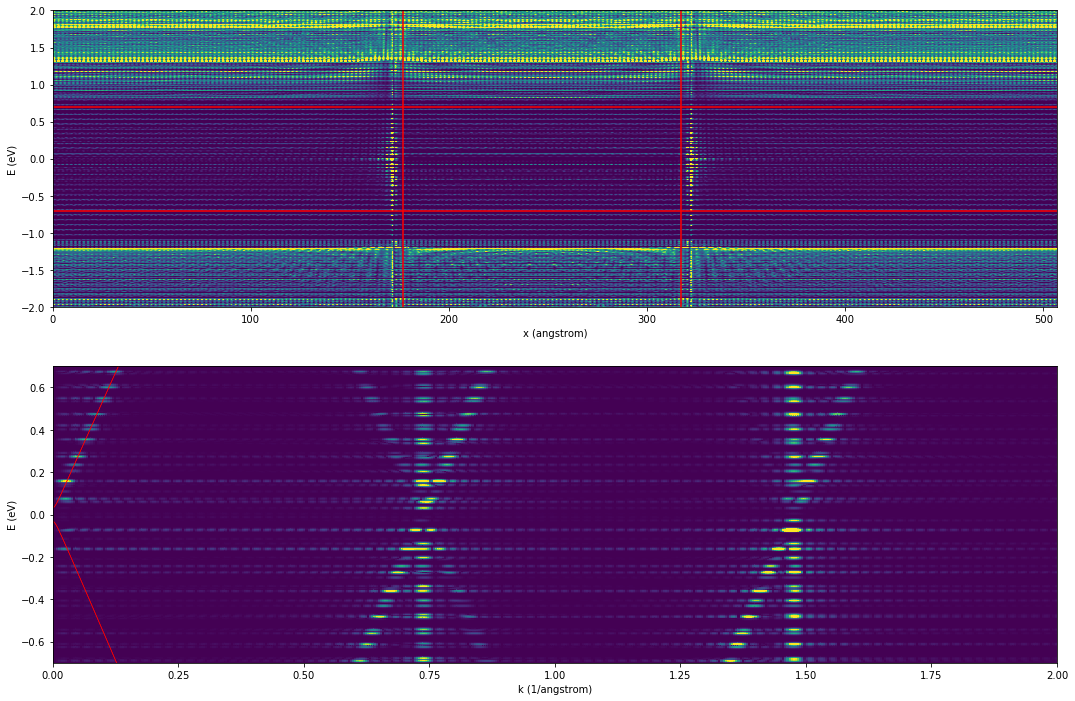

36.3281192779541


In [9]:
%matplotlib inline
time0 = time.time()
ftdata = plot_ldos(proc_out, "QE cnt 12,0", brightn = [0.1, 0.05, 2.0])
print(time.time() - time0)

In [10]:
lattice_param = 3*1.42
bzboundary = np.pi / lattice_param

In [11]:
ftdata_save = ftdata

In [12]:
ftdata = ftdata_save

In [ ]:
%matplotlib auto
k_arr, e_arr, aft = ftdata
k_grid, e_k_grid = np.meshgrid(k_arr, e_arr, indexing='ij')

plt.figure(figsize=(20, 8))

plt.pcolormesh(k_grid,
               e_k_grid,
               aft,
               vmax=0.3*np.max(aft))

add_qe_bands_to_plot("QE cnt 12,0", 'r', '-', 0.8, bzboundary)
plt.ylim([np.min(e_arr), np.max(e_arr)])
plt.xlim([0.0, 2.0])
plt.xlabel("k (1/angstrom)")
plt.ylabel("E (eV)")

#plt.savefig("./fig/ldos_sts/"+figname+".png", dpi=300, bbox_inches='tight')
plt.show()

# Measuring spacing

In [30]:
vac_A_de1_rp1_low = np.array([
    -0.125, -0.238, -0.345, -0.436, -0.540, -0.632
])
vac_A_de1_rp1_low[1:]-vac_A_de1_rp1_low[:-1]

array([-0.113, -0.107, -0.091, -0.104, -0.092])

In [31]:
vac_A_de1_rp1_high = np.array([
    0.093, 0.211, 0.342, 0.474, 0.603
])
vac_A_de1_rp1_high[1:]-vac_A_de1_rp1_high[:-1]

array([ 0.118,  0.131,  0.132,  0.129])

In [32]:
vac_A_de1_rp2_high = np.array([
    0.275, 0.343, 0.406, 0.473, 0.538, 0.604, 0.671
])
vac_A_de1_rp2_high[1:]-vac_A_de1_rp2_high[:-1]

array([ 0.068,  0.063,  0.067,  0.065,  0.066,  0.067])

In [20]:
1.76/15.336

0.11476264997391758

In [22]:
1.76/35.2

0.049999999999999996

In [23]:
1.76/50.5

0.034851485148514855

In [25]:
1.76/65.8

0.026747720364741642

658

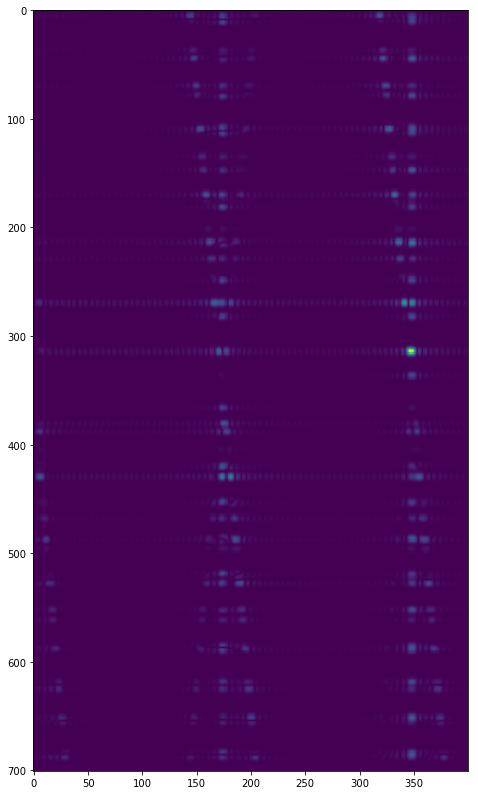

In [40]:
plt.figure(figsize=(14, 14))
plt.imshow(ftdata[2][:400, :].T)
plt.show()